In [4]:
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
import matplotlib.pyplot as plt

Download and prepare CIFAR10 dataset
The CIFAR10 dataset contains 60000 color images in 10 classes, with 6000 images in each class. The dataset dataset is divided into 50000 training images and 10k testing images. The classes are mutually exclusice and there is no overlap between them

In [5]:
(train_images,train_labels),(test_images,test_labels)=datasets.cifar10.load_data()
#Normalise pixel values to be between 0and 1
train_images,test_images=train_images/255.0,test_images/255.0

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


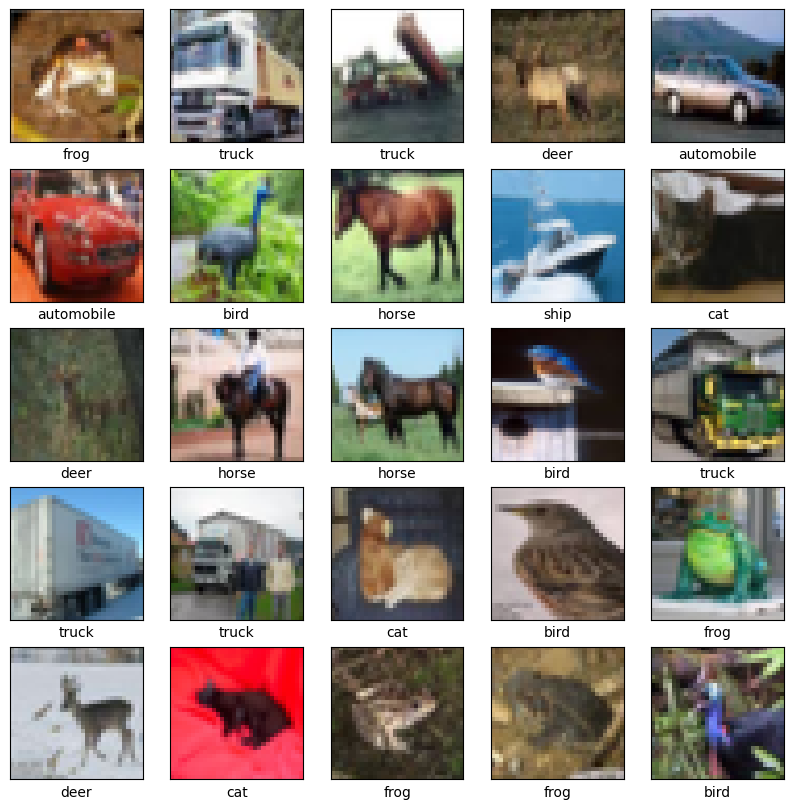

In [6]:
class_names=['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i])
    #The CIFAR labels happen to be arrays,
    #which is why you need the extra index
    plt.xlabel(class_names[train_labels[i][0]])
plt.show()

Create the convolutional base

The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layer.

As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to these dimensions, color channels refers to (R,G,B). In this example, you will configure your CNN to process inputs of shape (32. 32, 3), which is the format of CIFAR images. You can do this by passing the argument input shape to your first layer

In [7]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 56,320 (220.00 KB)

 Trainable params: 56,320 (220.00 KB)

 Non-trainable params: 0 (0.00 B)

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as you go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, you can afford (computationally) to add more output channels in each Conv2D layer.

Add Dense layers on top

To complete the model, you will feed the last output tensor from the convolutional base (of shape (4, 4, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, you will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. CIFAR has 10 output classes, so you use a final Dense layer with 10 outputs

In [9]:
model.add(layers.Flatten())#flatten layer L*h*channel
model.add(layers.Dense(64, activation='relu')) # fully connected layer
model.add(layers.Dense(10)) #o/p layer with 10 neuron

Here's the complete architecture of your model:

In [10]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 4, 4, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 122,570 (478.79 KB)

 Trainable params: 122,570 (478.79 KB)

 Non-trainable params: 0 (0.00 B)

compile and train the model

In [11]:
model.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])
history=model.fit(train_images,train_labels,epochs=10,validation_data=(test_images,test_labels))
#from_logits=True indicates that the model's output are raw logits (not probabilities),
#so the loss function internally applies a softmax

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 78s 48ms/step - accuracy: 0.3429 - loss: 1.7670 - val_accuracy: 0.5595 - val_loss: 1.2174
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 71s 45ms/step - accuracy: 0.5672 - loss: 1.2087 - val_accuracy: 0.5892 - val_loss: 1.1391
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 45ms/step - accuracy: 0.6347 - loss: 1.0229 - val_accuracy: 0.6461 - val_loss: 1.0053
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 70s 45ms/step - accuracy: 0.6782 - loss: 0.9078 - val_accuracy: 0.6823 - val_loss: 0.9126
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 80s 44ms/step - accuracy: 0.7036 - loss: 0.8409 - val_accuracy: 0.6859 - val_loss: 0.9038
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 83s 45ms/step - accuracy: 0.7323 - loss: 0.7723 - val_accuracy: 0.6955 - val_loss: 0.8740
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 82s 44ms/step - accuracy: 0.7458 - loss: 0.7227 - val_accuracy: 0.7016 - val_loss: 0.8776
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 89s 49ms/step - accuracy: 0.7572 -

Evaluate the model

313/313 - 5s - 17ms/step - accuracy: 0.7122 - loss: 0.8666
0.7121999859809875


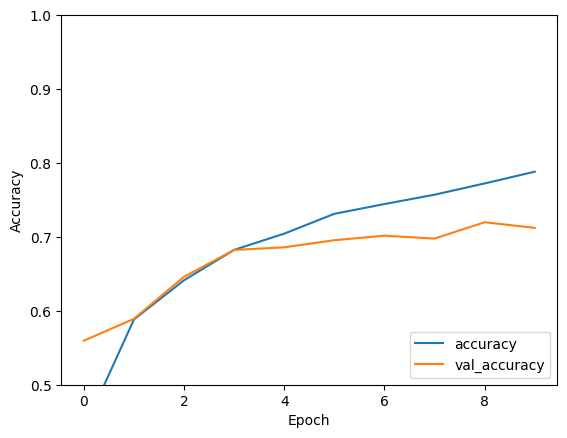

In [12]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5,1])
plt.legend(loc='lower right')
test_loss,test_acc=model.evaluate(test_images,test_labels,verbose=2)
print(test_acc)

In [14]:
# Make predictions on some test images, e.g., first 5
predictions = model.predict(test_images[5:10])

# Convert logits to probabilities
probabilities = tf.nn.softmax(predictions).numpy()

# Get predicted class indices
predicted_indices = tf.argmax(probabilities, axis=1).numpy()

# Map indices to class names
predicted_class_names = [class_names[idx] for idx in predicted_indices]

print(predicted_class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
['frog', 'automobile', 'frog', 'cat', 'automobile']


In [16]:
model.save('cifar10_model.h5')